In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)
X = np.random.randn(100,2)
X[:5]

array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ],
       [ 1.74481176, -0.7612069 ],
       [ 0.3190391 , -0.24937038]])

In [3]:
help(np.random.randn)

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
 

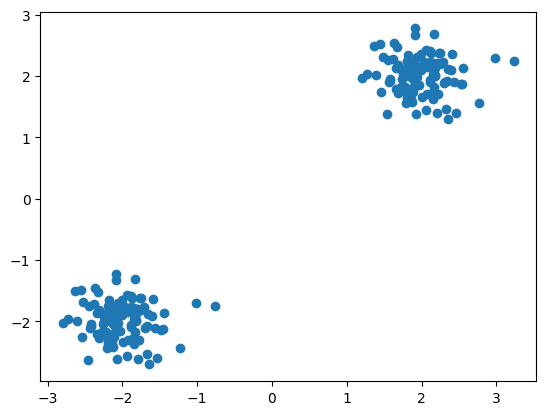

In [4]:
# generate two cluster
np.random.seed(2)
X_inliner = 0.3 * np.random.randn(100,2)
X_inliner = np.r_[X_inliner+2,X_inliner-2]

plt.scatter(X_inliner[:,0],X_inliner[:,1])

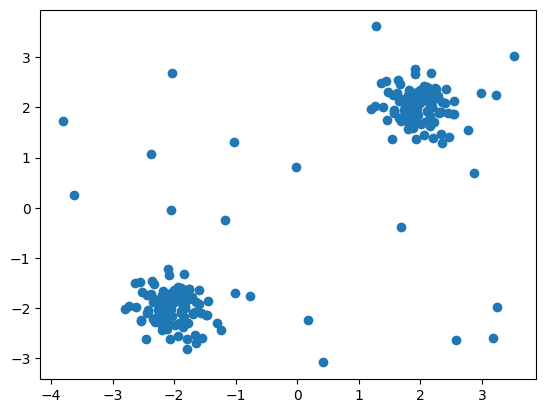

In [5]:
# add some outlier
np.random.seed(345)
X_outliers = np.random.uniform(low=-4,high=4,size=(20,2))
X = np.r_[X_inliner,X_outliers]

plt.scatter(X[:,0],X[:,1])

In [6]:
# ground truth
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X),dtype=int)
ground_truth[-n_outliers:] = -1

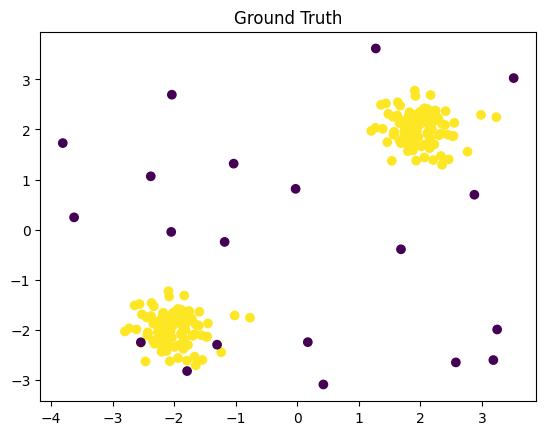

In [7]:
plt.scatter(X[:,0],X[:,1],c=ground_truth)
plt.title("Ground Truth")
plt.show()

In [8]:
# detecting the outlier
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
y_pred = clf.fit_predict(X)

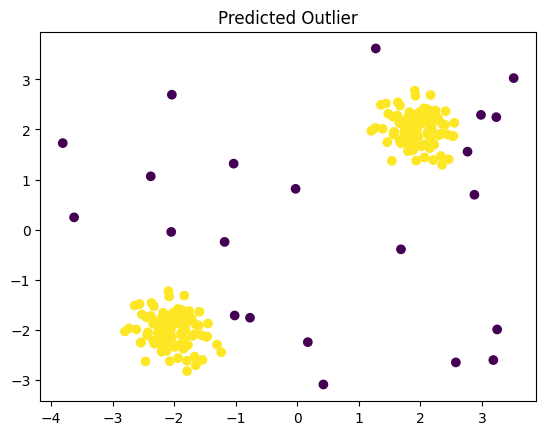

In [9]:
plt.scatter(X[:,0],X[:,1],c=y_pred)
plt.title("Predicted Outlier")
plt.show()

In [10]:
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

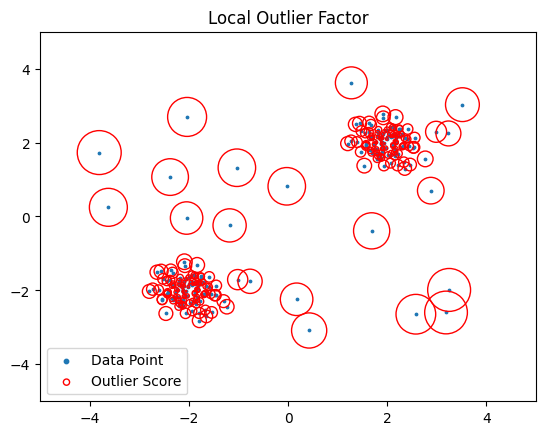

In [11]:
plt.title("Local Outlier Factor")
plt.scatter(X[:,0],X[:,1],s=3.0,label="Data Point")
radius = (X_scores.max() - X_scores) / (X_scores.max() -X_scores.min())
plt.scatter(
    X[:,0],
    X[:,1],
    s=1000*radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier Score"
)
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legends = plt.legend(loc="lower left")
legends.legendHandles[0]._sizes = [10]
legends.legendHandles[1]._sizes = [20]
plt.show()

In [29]:
from sklearn.base import BaseEstimator,OutlierMixin
from scipy.spatial.distance import euclidean

class CustomLocalOutlierFactor(BaseEstimator,OutlierMixin):
    def __init__(self,n_neighbours=20,contamination="auto"):

        self.n_neighbours = n_neighbours
        self.contamination = contamination

    def fit(self,X,y=None):
        self._fit_X = X
        self.n_sample, _ =X.shape
        self.distance ,self.neighbours_idx = self._kneighbors(self.n_neighbours)
        self._lrd = self._local_reachability_density(self.distance,self.neighbours_idx)

        lrd_ratios_array = (
            self._lrd[self.neighbours_idx] / self._lrd[:, np.newaxis]
        )

        self.negative_outlier_factor_ = -np.mean(lrd_ratios_array, axis=1)

        if self.contamination == "auto":
            self.offset = -1.5
        else:
            self.offset = np.percentile(
                self.negative_outlier_factor_,100*self.contamination
            )


        return self

    def predict(self,X):
        is_inlier =np.ones(self.n_sample,dtype=int)
        is_inlier[self.negative_outlier_factor_ < self.offset] = -1
        return is_inlier

    def _kneighbors(self,n_neighbors):
        # to account self count
        n_neighbors_ = n_neighbors + 1
        distance = np.array([euclidean(u,v)
                             for u in self._fit_X
                             for v in self._fit_X])
        distance = distance.reshape(self.n_sample,self.n_sample)
        neighbor_idx = distance.argsort(axis=1)
        return np.take_along_axis(distance,neighbor_idx[:,1:n_neighbors_],axis=1) , neighbor_idx[:,1:n_neighbors_]

    def _local_reachability_density(self,distance_,neighbor_index):
        dist_k = distance_[neighbor_index,self.n_neighbours-1]
        reach_dist = np.maximum(distance_,dist_k)
        lrd = 1.0 / (np.mean(reach_dist, axis=1) + 1e-10)
        return lrd




In [30]:
clf_ = CustomLocalOutlierFactor(n_neighbours=20,contamination=0.1)

In [32]:
y_cus_pred = clf_.fit_predict(X)

In [39]:
np.all(y_pred == y_cus_pred)

True

In [36]:
X_cus_scores = clf_.negative_outlier_factor_

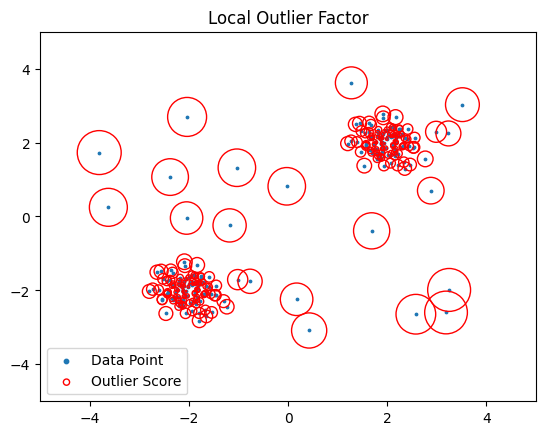

In [37]:
plt.title("Local Outlier Factor")
plt.scatter(X[:,0],X[:,1],s=3.0,label="Data Point")
radius = (X_cus_scores.max() - X_cus_scores) / (X_cus_scores.max() -X_cus_scores.min())
plt.scatter(
    X[:,0],
    X[:,1],
    s=1000*radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier Score"
)
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legends = plt.legend(loc="lower left")
legends.legendHandles[0]._sizes = [10]
legends.legendHandles[1]._sizes = [20]
plt.show()